In [ ]:
%config InlineBackend.figure_format = 'retina'

%config IPCompleter.use_jedi = False
import multiprocessing.popen_spawn_posix

import os
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd
from dask import delayed

import itertools as it
from functools import reduce
import treecorr

import matplotlib
import matplotlib.pyplot as plt

In [ ]:
matplotlib.rcParams['savefig.dpi'] = 120
matplotlib.rcParams['figure.dpi'] = 120

In [ ]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=6, 
                       threads_per_worker=1,
                       memory_limit='6Gb')
client = Client(cluster)

#dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"
#client = Client(scheduler_file='/global/cscratch1/sd/cwalter/scheduler.json')

client

In [ ]:
from scipy.special import comb

#scratch= os.environ["SCRATCH"]
scratch = '/Users/walter/LSST/work'

selected = ['id', 'mag_r', 'z', 'ra', 'dec', 'g1', 'g2']

#df = dd.read_parquet(f'{scratch}/parquet-skysim/*.parquet', columns=selected, engine='pyarrow')
df = dd.read_parquet(f'{scratch}/skysim-sampled/*.parquet', columns=selected, engine='pyarrow')
#df = df.persist()

number_in_df = df.index.size.compute()
print('Columns:', df.columns.values, '#Rows:', number_in_df/1e9)
print(f'There are {number_in_df:,d} elements in the area with {comb(number_in_df, 2, exact=True):,d} total combinations')

In [5]:
from healpy.pixelfunc import ang2pix
from healpy.pixelfunc import pix2ang
from healpy.rotator import angdist

NSIDE = 16

def add_healpixels(dataframe):
    return ang2pix(NSIDE, dataframe.ra.to_numpy(), dataframe.dec.to_numpy(), lonlat=True)

def angular_distance(pairs):
    
    pixel1 = pix2ang(NSIDE, pairs[:,0])
    pixel2 = pix2ang(NSIDE, pairs[:,1])
    seperation = angdist(pixel1, pixel2)*180/np.pi*60 # in arcmin
    
    return seperation

@delayed
def cross(dataframe1, dataframe2, pixel1, pixel2):
    
    gg = treecorr.GGCorrelation(min_sep=1., max_sep=200., nbins=20, num_threads=1, sep_units='arcmin')

    if dataframe1 is dataframe2:   
        #print(pixel1, pixel2, "same!")
        cat1 = treecorr.Catalog(ra=dataframe1.ra, dec=dataframe1.dec, g1=dataframe1.g1, g2=dataframe1.g2, flip_g2=True, ra_units='deg', dec_units='deg')
        gg.process_auto(cat1)
        
    else:
        #print(pixel1, pixel2, "different!")
        cat1 = treecorr.Catalog(ra=dataframe1.ra, dec=dataframe1.dec, g1=dataframe1.g1, g2=dataframe1.g2, flip_g2=True, ra_units='deg', dec_units='deg')
        cat2 = treecorr.Catalog(ra=dataframe2.ra, dec=dataframe2.dec, g1=dataframe2.g1, g2=dataframe2.g2, flip_g2=True, ra_units='deg', dec_units='deg')
        gg.process_cross(cat1, cat2)
        
    return gg

def calculateVariance(dataframe):
    cat = treecorr.Catalog(ra=dataframe.ra, dec=dataframe.dec, g1=dataframe.g1, g2=dataframe.g2, flip_g2=True, ra_units='deg', dec_units='deg')
    return pd.DataFrame([[cat.varg*cat.sumw, cat.sumw]])

In [6]:
df['pixel'] = df.map_partitions(add_healpixels)

pixelated = df.set_index('pixel')
pixel_list = list(pixelated.index.unique())
pixelated = pixelated.repartition(pixel_list + [pixel_list[-1]])
pixelated = pixelated.persist()

delayed_list = pixelated.to_delayed()
partition_map = {j:i for i,j in enumerate(pixel_list)}

In [9]:
elements = pixelated.map_partitions(calculateVariance).sum().compute()
varg = elements[0]/elements[1]

pairs = np.array( [x for x in it.combinations_with_replacement(pixel_list, 2)] )
selected_pairs = pairs[angular_distance(pairs) < 600]

In [10]:
%%time

a = [ cross( delayed_list[partition_map[i[0]]], delayed_list[partition_map[i[1]]], i[0], i[1] ) for i in selected_pairs]

gg = reduce(treecorr.GGCorrelation.__iadd__, dask.compute(*a))
gg.finalize(varg, varg)

CPU times: user 2min 34s, sys: 7.72 s, total: 2min 42s
Wall time: 16min 45s


CPU times: user 20min 8s, sys: 26 s, total: 20min 34s
Wall time: 4min 43s


Text(0.5, 0, '$\\theta$ (arcmin)')

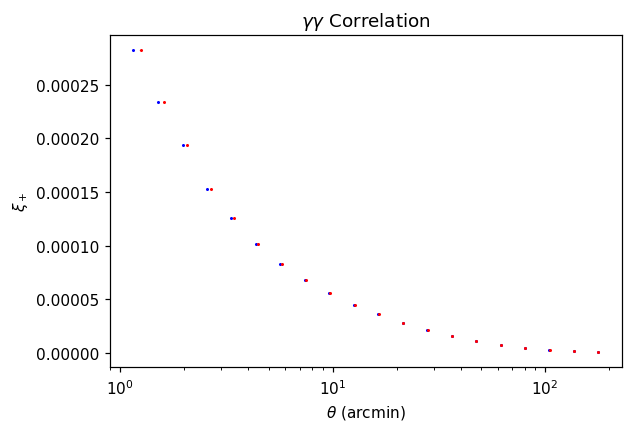

In [12]:
%%time

plt.errorbar(gg.meanr, gg.xip, yerr=np.sqrt(gg.varxip), color='blue', marker='.', markersize=2, ls='none')

#cat_raw = treecorr.Catalog(ra=df.ra, dec=df.dec, g1=df.g1, g2=df.g2, flip_g2=True, ra_units='deg', dec_units='deg')
#gg_raw = treecorr.GGCorrelation(min_sep=1., max_sep=200., nbins=20, sep_units='arcmin')
#gg_raw.process(cat_raw)
#plt.errorbar(gg_raw.meanr+.1, gg_raw.xip, yerr=np.sqrt(gg_raw.varxip), color='red' ,marker='.', markersize=2, ls='none', label='Treecorr')

plt.title('$\gamma \gamma$ Correlation')
plt.xscale('log')
plt.ylabel(r'$\xi_+$')
plt.xlabel(r'$\theta$ (arcmin)')